# COVID 19 DETECTION

## Libraries

In [62]:
import numpy as np
import keras
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from sklearn.metrics import classification_report

## Google Conection

In [63]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Unzip

In [64]:
YOUR_FILE_ID = '1kEL9YqW4Ylrh0ilWdxvBUyuZ5kvMJnxe'
filename = 'DATASET_TRAIN_TEST_RES.zip'

download = drive.CreateFile({'id': YOUR_FILE_ID})
download.GetContentFile(filename)

import zipfile
zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall()
zip_ref.close()

## File Names

In [65]:
#Dirección de la base de datos original
base_dir = 'DATASET_TRAIN_TEST_RES'
train_dir = os.path.join(base_dir, 'Train')
#validation_dir = os.path.join(base_dir, 'Validation') 
test_dir = os.path.join(base_dir, 'Test')

#Carpetas con imágenes de entrenamiento covid y normal
train_covid_dir = os.path.join(train_dir,'COVID19')
train_neumonia_dir = os.path.join(train_dir,'Neumonía')
train_normal_dir = os.path.join(train_dir,'Normal')

#Carpetas con imágenes de test covid y normal
test_covid_dir = os.path.join(test_dir,'COVID19')
test_normal_dir = os.path.join(test_dir,'Normal')
test_neumonia_dir = os.path.join(test_dir,'Neumonía')

# Lista de nombres de imágenes
lis_cov1 = os.listdir(train_covid_dir)
lis_nor1 = os.listdir(train_normal_dir)
lis_pneu1 = os.listdir(train_neumonia_dir)

lis_cov2 = os.listdir(test_covid_dir)
lis_nor2 = os.listdir(test_normal_dir)
lis_pneu2 = os.listdir(test_neumonia_dir)

## Image to Array

In [66]:
cov = []
nor = []
pneu = []

for i in range(0, 450):
  foo = Image.open('DATASET_TRAIN_TEST_RES/Train/{}/{}'.format('COVID19', lis_cov1[i])).convert('LA').resize((250,250))
  cov.append(np.array(foo.getdata())[:,0].reshape(250, 250)/255)

for i in range(0, 450):
  foo = Image.open('DATASET_TRAIN_TEST_RES/Train/{}/{}'.format('Normal', lis_nor1[i])).convert('LA').resize((250,250))
  nor.append(np.array(foo.getdata())[:,0].reshape(250, 250)/255)

for i in range(0, 450):
  foo = Image.open('DATASET_TRAIN_TEST_RES/Train/{}/{}'.format('Neumonía', lis_pneu1[i])).convert('LA').resize((250,250))
  pneu.append(np.array(foo.getdata())[:,0].reshape(250, 250)/255)

###############################################################
for i in range(0, 150):
  foo = Image.open('DATASET_TRAIN_TEST_RES/Test/{}/{}'.format('COVID19', lis_cov2[i])).convert('LA').resize((250,250))
  cov.append(np.array(foo.getdata())[:,0].reshape(250, 250)/255)

for i in range(0, 150):
  foo = Image.open('DATASET_TRAIN_TEST_RES/Test/{}/{}'.format('Normal', lis_nor2[i])).convert('LA').resize((250,250))
  nor.append(np.array(foo.getdata())[:,0].reshape(250, 250)/255)

for i in range(0, 150):
  foo = Image.open('DATASET_TRAIN_TEST_RES/Test/{}/{}'.format('Neumonía', lis_pneu2[i])).convert('LA').resize((250,250))
  pneu.append(np.array(foo.getdata())[:,0].reshape(250, 250)/255)

## Image Preprocessing

In [67]:
covid = np.array(cov)
normal = np.array(nor)
pneumonia = np.array(pneu)

X_complete = np.array([covid, normal, pneumonia]).reshape(1800, 250, 250, 1)

## Creating Labels

In [68]:
y_cov = np.full((600), 0)
y_nor = np.full((600), 1)
y_pneu = np.full((600), 2)

y_unique = np.array([y_cov, y_nor, y_pneu]).reshape(600*3)
y = to_categorical(y_unique)

## Label Dictionary

In [69]:
dic_label = {0: 'Covid', 1: 'Health', 2: 'Pneumonia'}

## Shuffle

In [70]:
shuff = np.arange(1800)
np.random.shuffle(shuff)

X = X_complete[shuff]
y = y[shuff]

## Set Separation

In [71]:
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size = .5)

## Neural Network

In [72]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (250, 250, 1)))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(512, (3,3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation= 'relu'))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 248, 248, 64)      640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 124, 124, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 122, 122, 128)     73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 61, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 59, 59, 512)       590336    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 29, 29, 512)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 430592)           

In [73]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

hist = model.fit(X_train, y_train, batch_size=128, epochs= 30, validation_data=(X_val, y_val))

Epoch 1/30
12/12 [==============================] - 6s 539ms/step - loss: 2.1407 - acc: 0.4264 - val_loss: 0.9330 - val_acc: 0.3833
Epoch 2/30
12/12 [==============================] - 6s 527ms/step - loss: 0.6048 - acc: 0.7563 - val_loss: 0.3942 - val_acc: 0.8722
Epoch 3/30
12/12 [==============================] - 6s 532ms/step - loss: 0.3209 - acc: 0.8875 - val_loss: 0.3120 - val_acc: 0.9222
Epoch 4/30
12/12 [==============================] - 6s 536ms/step - loss: 0.3248 - acc: 0.8840 - val_loss: 0.2970 - val_acc: 0.9389
Epoch 5/30
12/12 [==============================] - 6s 541ms/step - loss: 0.2275 - acc: 0.9181 - val_loss: 0.3189 - val_acc: 0.9333
Epoch 6/30
12/12 [==============================] - 6s 539ms/step - loss: 0.2702 - acc: 0.9090 - val_loss: 0.2406 - val_acc: 0.9333
Epoch 7/30
12/12 [==============================] - 7s 543ms/step - loss: 0.1807 - acc: 0.9375 - val_loss: 0.2112 - val_acc: 0.9444
Epoch 8/30
12/12 [==============================] - 6s 541ms/step - loss: 0.

<function matplotlib.pyplot.show>

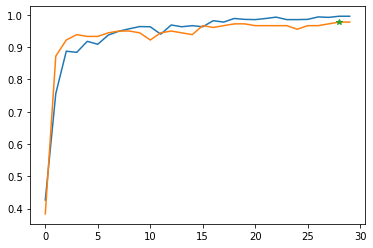

In [74]:
val = np.argmax(hist.history['val_acc'])
plt.plot(hist.history['acc'], label = 'Train acc')
plt.plot(hist.history['val_acc'], label = 'Val acc')
plt.plot(val, np.max(hist.history['val_acc']), '*')
plt.show

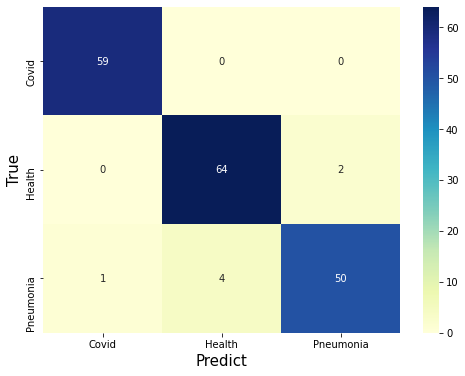

In [75]:
pred = list(map(lambda x: dic_label[x], model.predict_classes(X_test)))
labels = list(map(lambda x: dic_label[x], [np.argmax(x) for x in y_test]))
axis_lab = list(dic_label.values())
cm = confusion_matrix(labels, pred)
plt.figure(figsize = (8, 6))
heatmap(cm, annot = True, xticklabels= axis_lab,  yticklabels = axis_lab, cmap = "YlGnBu")
plt.xlabel('Predict', fontsize=15) # x-axis label with fontsize 15
plt.ylabel('True', fontsize=15) # y-axis label with fontsize 15
plt.show()

In [76]:
print(classification_report(labels, pred))

              precision    recall  f1-score   support

       Covid       0.98      1.00      0.99        59
      Health       0.94      0.97      0.96        66
   Pneumonia       0.96      0.91      0.93        55

    accuracy                           0.96       180
   macro avg       0.96      0.96      0.96       180
weighted avg       0.96      0.96      0.96       180



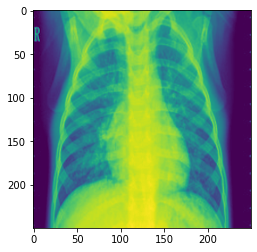

'Pneumonia'

In [77]:
ind = np.random.randint(0, X_test.shape[0])
plt.imshow(X_test[ind].reshape(250, 250))
plt.show()
dic_label[model.predict_classes(X_test)[ind]]